# Fluxo Novo

Ordem das células

- Importando base de dados
- Definindo lojas que estarão no relatório
- Definindo dia do relatório
- Definindo emails que receberão o relatório
- Rodando o código para a criação do relatório
- Preparando o html
- Rodando Mock do disparador de email e disparando email

## Importando base de dados

- Filtra o df_fato_vendas para dados de 2424 em diante

In [16]:
# -> Rodar tudo para ter os dataframes corretos
from commom.database.queries.query_lojas import QUERY_LOJAS
from commom.database.queries.query_vendas_nf_novo import QUERY_VENDAS_NF_NOVO
from commom.database.queries.query_metas import QUERY_METAS
from commom.database.queries.query_parcelas import QUERY_PARCELAS
from commom.database.queries.query_vendas_nf import QUERY_VENDAS_NF
from commom.database.queries.query_vendedores import QUERY_VENDEDORES
from commom.database.queries.query_loja_vendedores import QUERY_LOJA_VENDEDORES
from commom.kpi_data.kpi_data_manager import DataHandler, KpiDataManager
from typing import Tuple
import numpy as np
import pandas as pd
import datetime
from datetime import timedelta
from innovation_messenger import Messenger
import os
from innovation_messenger import IEmailProperties
import missingno as msno

manager = KpiDataManager()
handler = DataHandler()

# Service
## -> inicio
###     -> fetch data from local pickle
df_fato_vendas = handler.read_from_local_pickle('df_fato_vendas.pkl')
df_lojas = handler.read_from_local_pickle('df_lojas.pkl')
df_vendedores = handler.read_from_local_pickle('df_vendedores.pkl')
df_vendas = handler.read_from_local_pickle('df_vendas.pkl')
df_parcelas = handler.read_from_local_pickle('df_parcelas.pkl')
df_metas = handler.read_from_local_pickle('df_metas.pkl')
df_vendedor_loja = handler.read_from_local_pickle('df_vendedor_loja.pkl')

###     -> fetch data from bq
# df = handler.read_from_bigquery(QUERY_VENDAS_NF_NOVO)
# df_lojas = handler.read_from_bigquery(QUERY_LOJAS)
# df_vendedores = handler.read_from_bigquery(QUERY_VENDEDORES)
# df_vendas = handler.read_from_bigquery(QUERY_VENDAS_NF)
# df_parcelas = handler.read_from_bigquery(QUERY_PARCELAS)
# df_metas = handler.read_from_bigquery(QUERY_METAS).rename(
#     columns={"cpf_vendedor": "cpf_vendedor_inteiro", "loja": "distributorId"}
# )
# df_vendedor_loja = handler.read_from_bigquery(QUERY_LOJA_VENDEDORES)

In [23]:
# debug
# fato_vendas_copy = df_fato_vendas.copy()
# vendas_copy = df_vendas.copy()

# PDV_TYPE_LIST = ['Propria']

# PDVTYPELIST = ["STORE", "PI - 360", "PI", "EP", "REFUND"]

# maskpdv = vendas_copy["tipo_transacao"].isin(PDVTYPELIST)

# vendas_copy = vendas_copy[maskpdv]
# vendas_copy.loc[:, "tipo_transacao"] = vendas_copy["tipo_transacao"].replace("PI - 360", "STORE")
# vendas_copy.loc[:, "tipo_transacao"] = vendas_copy["tipo_transacao"].replace("PI", "STORE")
# vendas_copy.loc[:, "tipo_transacao"] = vendas_copy["tipo_transacao"].replace("EP", "STORE")


# mask_pdv = fato_vendas_copy["type"].isin(PDV_TYPE_LIST)
# maksNull = fato_vendas_copy['distributorId'].isnull()

# fato_vendas_copy = fato_vendas_copy[mask_pdv & ~maksNull]
# fatovendasLojasIds = fato_vendas_copy['distributorId'].unique().tolist()
# vendasLojasIds = vendas_copy['distributorId'].unique()

# currentStores = []
# for store in fatovendasLojasIds:
#     if store in vendasLojasIds:
#         currentStores.append(store)

# print(currentStores)
# len(currentStores)

## Definindo lojas que estarão no relatório

In [24]:
# codigo para pegar loja e data aleatoria
import random
import datetime

currentStores = ['10H1', '10I9', '10J3', '1077', '10I1', '10I4', '10J9', '10G2', '1086', '10H5', '10G6', '10J4', '10J7', '10i6', '10I8', '0091', '10J0', '10J5', '10G8', '10I3', '10J1', '10J8', '10L9', '10L7', '10L8', '10L0', '10I5', '10J2', '10M1', '10M0', '10F9', '10C4', '10M2', '1010', '1012', '1017', '1018', '1021', '1022', '1025', '1027', '1028', '1036', '1043', '1044', '1045', '1049', '1052', '1054', '1055', '1065', '1068', '1071', '1089', '10C2', '10E2', '10E4', '10E5', '10F3', '10F8']

numero_aleatorio_loja = random.randint(0, 60)

lojaAtual = currentStores[numero_aleatorio_loja]
print('loja', lojaAtual)

loja 10I4


In [11]:
# codigo para definir loja fixa

currentStores = ['10H1', '10I9', '10J3', '1077', '10I1', '10I4', '10J9', '10G2', '1086', '10H5', '10G6', '10J4', '10J7', '10i6', '10I8', '0091', '10J0', '10J5', '10G8', '10I3', '10J1', '10J8', '10L9', '10L7', '10L8', '10L0', '10I5', '10J2', '10M1', '10M0', '10F9', '10C4', '10M2', '1010', '1012', '1017', '1018', '1021', '1022', '1025', '1027', '1028', '1036', '1043', '1044', '1045', '1049', '1052', '1054', '1055', '1065', '1068', '1071', '1089', '10C2', '10E2', '10E4', '10E5', '10F3', '10F8']

lojaAtual = '1077'
print('loja', lojaAtual)

loja 1077


## Definindo data do relatório

In [29]:
# codigo para definir data aleatória
###     -> self date
import datetime
import random

maskStore = df_fato_vendas['distributorId'] == lojaAtual
data_inicial = df_fato_vendas[maskStore]['createdAt'].min()
data_final = df_fato_vendas[maskStore]['createdAt'].max()

dias_diferenca = (data_final - data_inicial).days
dias_aleatorio = random.randint(0, dias_diferenca)
yesterday_date = data_inicial + datetime.timedelta(days=dias_aleatorio)

print('dia escolhido ', yesterday_date)
print('loja', lojaAtual)

dia escolhido  2024-03-31 00:00:00
loja 10I4


In [12]:
# codigo para definir data fixa
yesterday_date = datetime.datetime(2025,1,21)
print('dia escolhido ', yesterday_date)
print('loja', lojaAtual)

dia escolhido  2025-01-21 00:00:00
loja 1077


## Definindo emails que estarão no relatório

In [14]:
emailRecipients = [
    'joao.garcia@ammovarejo.com.br',
    # 'rodrigo.chiesa@coteminas.com.br',
    # 'inovacao@ammovarejo.com.br'
]
print("Lista de recipients", emailRecipients)

Lista de recipients ['joao.garcia@ammovarejo.com.br']


## Rodando código para criação do relatório

In [17]:
print('dia escolhido ', yesterday_date)
print('loja', lojaAtual)

def _abreviate_vendedor_name(full_name: str) -> str:
    full_name = full_name.replace("   ", " ")
    full_name = full_name.replace("  ", " ")

    if len(full_name.title().split(" ")) > 1:
        splited_name = full_name.title().split(" ")
        nome_completo = splited_name[0]
        splited_name.pop(0)

        for name in splited_name:
            nome_completo += " " + name[0] + "."

        return nome_completo

    return full_name

# ----------------------------------------
# ----------------------------------------

def build_df_vendas():
    df_vendas_temp = df_fato_vendas.copy()

    PDV_TYPE_LIST = ['Propria']

    mask_pdv = df_vendas_temp["type"].isin(PDV_TYPE_LIST)
    maksNull = df_vendas_temp['distributorId'].isnull()
    df_vendas_pdv = df_vendas_temp[mask_pdv & ~maksNull]
    df_vendas_pdv = df_vendas_pdv.copy()
    df_vendas_pdv['createdAt'] = pd.to_datetime(df_vendas_pdv['createdAt'])
    
    renameDict = {
        'displayCode': 'displaycode',
        'vendedor_esforco': 'cpf_vendedor_inteiro',
        'esforco_data': 'invoice_date'
    }

    df_vendas_pdv = df_vendas_pdv.reset_index(drop=True)
    
    df_vendas_pdv['year'] = df_vendas_pdv['createdAt'].dt.year
    df_vendas_pdv['month'] = df_vendas_pdv['createdAt'].dt.month
    df_vendas_pdv['day'] = df_vendas_pdv['createdAt'].dt.day
    
    df_vendas_pdv.rename(columns=renameDict, inplace=True)
    return df_vendas_pdv

# ----------------------------------------
# ----------------------------------------

# Pode ser melhorador para já devolver o cpf_vendedor com a loja eo nome
def build_vendedor():
    df_nome_vendedor = df_vendedores[["name", "cpf"]]
    df_nome_vendedor.columns = ["vendedor", "cpf_vendedor_inteiro"]
    df_nome_vendedor.loc[:, "vendedor"] = df_nome_vendedor["vendedor"].apply(_abreviate_vendedor_name)
    return df_nome_vendedor

# ----------------------------------------
# ----------------------------------------

def build_masks_meta_vendedor(periodo,df_metas:pd.DataFrame, date: datetime.datetime):
    mask_meta = df_metas["tipo_meta"] == "Meta Vendedor PDV"
    if periodo == "Dia":
        mask_metas_yesterday = df_metas["date"] == date
        # mask_metas_yesterday = df_metas["date"] == yesterday_date
        mask_meta = mask_meta & mask_metas_yesterday
    
    return mask_meta

def build_kpis_dataframe_vendedor(kpi_period_:str, df_vendas_pdv_: pd.DataFrame):
    maskmeta = build_masks_meta_vendedor(periodo=kpi_period_, df_metas=df_metas, date=yesterday_date)
    AGG_DICT = {"discount": "sum", "netValue": "sum", "cost": "sum", "store_cost": "sum"}

    GROUP_BY_COLUMNS_DICT = {
        "Ano": ["distributorId", "year","cpf_vendedor_inteiro"],
        "Mês": ["distributorId", "year", "month", "cpf_vendedor_inteiro"],
        "Dia": ["distributorId", "year", "month", "cpf_vendedor_inteiro"],
    }

    group_by_columns = GROUP_BY_COLUMNS_DICT[kpi_period_]
    
    df_kpis: pd.DataFrame = df_vendas_pdv_.groupby(group_by_columns).agg(AGG_DICT).reset_index()

    df_kpis = df_kpis.merge(
        df_vendas_pdv_.groupby(group_by_columns)["fiscalsParentOrder"].nunique().reset_index().rename(columns={"fiscalsParentOrder": "tkts"}),
        how="left",
        )

    df_kpis = df_kpis.merge(
        df_vendas_pdv_.groupby(group_by_columns)["amount"].sum().reset_index(), 
        how="left"
    )

    df_kpis = df_kpis.merge(
        df_metas[maskmeta].groupby(group_by_columns)["meta"].sum().reset_index(), 
        how="left"
    )
        
    group_by_columns.remove('distributorId')
    df_kpis = df_kpis.merge(
        df_vendas_pdv_.groupby(group_by_columns)["invoice_date"]
        .nunique()
        .reset_index()
        .rename(columns={"invoice_date": "days_of_work"}),
        how="left",
    )

    if kpi_period_ == "Dia":
        df_kpis["Dia"] = yesterday_date.day

    if kpi_period_ == "Mês":
        df_kpis["tkts_per_day"] = df_kpis["tkts"] / df_kpis["days_of_work"].round(2)
    else:
        df_kpis["tkts_per_day"] = df_kpis["tkts"]

    df_kpis["type"] = kpi_period_

    df_kpis["mkp"] = (df_kpis["netValue"] / df_kpis["cost"]).round(2)
    
    df_kpis["tkt_medio"] = df_kpis["netValue"] / df_kpis["tkts"].round(2)
    df_kpis["meta_percentual"] = (df_kpis["netValue"] / df_kpis["meta"] * 100).round(2)
    df_kpis["PA"] = df_kpis["amount"] / df_kpis["tkts"].round(2)
    df_kpis["discount_percentual"] = ((df_kpis["discount"] / df_kpis["netValue"]) * 100).round(2)
    
    return df_kpis

# ----------------------------------------
# ----------------------------------------

def build_masks_meta_loja(periodo:str,  df_vendas_:pd.DataFrame ,df_metas:pd.DataFrame, date: datetime.datetime):
    mask_meta = df_metas["tipo_meta"] == "Meta Loja PDV"
    mask_vendas = pd.Series(np.ones(df_vendas_.shape[0]).astype(bool))
    
    if periodo == "Dia":
        mask_metas_yesterday = df_metas["date"] == date
        mask_yesterday_vendas = df_vendas_["invoice_date"] == yesterday_date
        mask_vendas = mask_yesterday_vendas
        

        mask_metas_yesterday = df_metas["date"] == yesterday_date
        mask_meta = mask_meta & mask_metas_yesterday

    return mask_vendas, mask_meta


def build_kpis_dataframe_loja(kpi_period_, df_vendas_pdv_:pd.DataFrame):
    maskVendas, maskMeta = build_masks_meta_loja(periodo=kpi_period_, df_vendas_= df_vendas_pdv, df_metas=df_metas, date=yesterday_date)
    AGG_DICT = {"discount": "sum", "netValue": "sum", "cost": "sum"}

    GROUP_BY_COLUMNS_DICT = {
        "Ano": ["distributorId", "year"],
        "Mês": ["distributorId", "year", "month"],
        "Dia": ["distributorId", "year", "month", 'day'],
    }

    group_by_columns = GROUP_BY_COLUMNS_DICT[kpi_period_]
    
    df_kpis: pd.DataFrame = df_vendas_pdv_[maskVendas].groupby(group_by_columns).agg(AGG_DICT).reset_index()

    df_kpis = df_kpis.merge(
        df_vendas_pdv_.groupby(group_by_columns)["fiscalsParentOrder"].nunique().reset_index().rename(columns={"fiscalsParentOrder": "tkts"}),
        how="left",
        )

    df_kpis = df_kpis.merge(
        df_vendas_pdv_.groupby(group_by_columns)["amount"].sum().reset_index(), 
        how="left"
    )

    df_kpis = df_kpis.merge(
        df_metas[maskMeta].groupby(group_by_columns)["meta"].sum().reset_index(), 
        how="left"
    )
    
    if kpi_period_ == "Dia":
        df_kpis["Dia"] = yesterday_date.day
    
    if kpi_period_ == "Dia":
        df_kpis["tkts_per_day"] = df_kpis["tkts"]
    if kpi_period_ == "Mês":
        df_kpis["tkts_per_day"] = df_kpis["tkts"] / yesterday_date.day
    if kpi_period_ == "Ano":
        df_kpis["tkts_per_day"] = df_kpis["tkts"] / yesterday_date.timetuple().tm_yday 
     
    df_kpis["type"] = kpi_period_
    df_kpis["mkp"] = (df_kpis["netValue"] / df_kpis["cost"]).round(2)
    df_kpis["tkt_medio"] = (df_kpis["netValue"] / df_kpis["tkts"]).round(2)
    df_kpis["meta_percentual"] = (df_kpis["netValue"] / df_kpis["meta"] * 100).round(2)
    df_kpis["PA"] = (df_kpis["amount"] / df_kpis["tkts"]).round(2)
    df_kpis["discount_percentual"] = ((df_kpis["discount"] / df_kpis["netValue"]) * 100).round(2)
    
    return df_kpis

# ----------------------------------------
# ----------------------------------------

def format_kpi_loja(id_loja: str, df_kpi:pd.DataFrame):
    mask = df_kpi["distributorId"] == id_loja

    df_store = df_kpi[mask].fillna(0).copy()
    df_store_current_month = df_store.loc[df_store.groupby(["type"])["month"].idxmax()].drop_duplicates()
    
    rename_dict = {
        "netValue": "Venda Loja (PDV)",
        "meta": "Meta Loja (PDV)",
        "meta_percentual": "Meta % (PDV)",
        "mkp": "Markup",
        "tkts_per_day": "Tickets/Dia",
        "PA": "Peças por Atendimento",
        "tkt_medio": "Ticket Médio",
        "discount_percentual": "Desconto Médio %",
        "type": "Período",
    }

    format_money = "R$ {:,.0f}"
    format_percentage = "{:,.0f}%"

    format_dict = {
        "Venda Loja (PDV)": format_money,
        "Meta Loja (PDV)": format_money,
        "Meta % (PDV)": format_percentage,
        "Markup": "{:,.2f}",
        "Tickets/Dia": "{:,.1f}",
        "Peças por Atendimento": "{:,.1f}",
        "Ticket Médio": format_money,
        "Desconto Médio %": format_percentage,
    }

    df_store_formated = df_store_current_month[rename_dict.keys()].round(2).rename(columns=rename_dict)

    for key, format in format_dict.items():
        df_store_formated[key] = df_store_formated[key].map(format.format)

        if format == format_money:
            df_store_formated[key] = df_store_formated[key].astype(str).str.replace(",", ".")

    try:
        df_store_formated = df_store_formated.set_index("Período").reset_index().T[[1, 2, 0]]
    except KeyError:
        df_store_formated = pd.DataFrame()
    
    return df_store_formated

# ----------------------------------------
# ----------------------------------------

def format_kpi_vendedor(id_loja:str, kpi_df_vendedor:pd.DataFrame, vendedor_loja_df:pd.DataFrame, periodo: str):
    format_money = "R$ {:,.0f}"
    format_percentage = "{:,.0f}%"
    
    # Tudo deveria vir do build vendedor
    df_nome_vendedor = build_vendedor()
    maskvendedorLoja = vendedor_loja_df['distributorId'] == id_loja
    vendedor_loja_df = vendedor_loja_df[maskvendedorLoja].copy()
    listCpf = vendedor_loja_df['employeeCpf'].tolist()
    # ----
    
    mask = kpi_df_vendedor["distributorId"] == id_loja
    df_vendedor = kpi_df_vendedor[mask].reset_index(drop=True)
    df_vendedor["Mês"] = df_vendedor["month"].fillna(0)

    mask_mes = df_vendedor["Mês"] == yesterday_date.month
    mask_ano = df_vendedor["year"] == yesterday_date.year
    
    if periodo == "Dia":
        mask_type = df_vendedor["type"].isin(["Dia"])
        mask_dia = df_vendedor['Dia'] == yesterday_date.day
        mask_completa = mask_type & mask_dia & mask_mes & mask_ano
    else:
        mask_type = df_vendedor["type"].isin(["Mês"])
        mask_completa = mask_type & mask_mes & mask_ano
        
    df_vendedor_filtro: pd.DataFrame = df_vendedor[mask_completa].reset_index(drop=True)
    
    df_vendedor_filtro["normalized_net_value"] = (
        df_vendedor_filtro["netValue"] * 100 / round(df_vendedor_filtro["netValue"].max(), 2)
    )
    
    df_vendedor_filtro["net_value_share"] = (
        df_vendedor_filtro["netValue"] * 100 / round(df_vendedor_filtro["netValue"].max(), 2)
    )
    
    maskCpf = df_vendedor_filtro['cpf_vendedor_inteiro'].isin(listCpf)
    df_vendedor_filtro = df_vendedor_filtro[maskCpf]
    df_vendedor_filtro = df_nome_vendedor.merge(df_vendedor_filtro, on="cpf_vendedor_inteiro").drop(
        columns="cpf_vendedor_inteiro"
    )
    
    if periodo == "Dia":
        rename_dict = {
            "vendedor": "Vendedor",
            "netValue": "Acumulado no Dia",
            "normalized_net_value": "Homogeneidade",
            "meta": "Meta do Dia",
            "meta_percentual": "Meta %",
            "mkp": "Markup",
            "tkts_per_day": "Tickets",
            "PA": "Peças por Atendimento",
            "tkt_medio": "Ticket Médio",
            "discount_percentual": "Desconto Médio %",
        }
        
        format_dict = {
            "Acumulado no Dia": format_money,
            "Homogeneidade": format_percentage,
            "Meta do Dia": format_money,
            "Meta %": format_percentage,
            "Markup": "{:,.2f}",
            "Tickets": "{:,.0f}",
            "Peças por Atendimento": "{:,.1f}",
            "Ticket Médio": format_money,
            "Desconto Médio %": format_percentage,
        }
        
        df_vendedor_formatado = (
            df_vendedor_filtro[rename_dict.keys()]
            .sort_values("normalized_net_value", ascending=False)
            .rename(columns=rename_dict)
        )
        
    else:
        rename_dict = {
            "vendedor": "Vendedor",
            "days_of_work": "Dias Trabalhados",
            "netValue": "Acumulado no Mês",
            "normalized_net_value": "Homogeneidade",
            "meta": "Meta do Mês",
            "meta_percentual": "Meta %",
            "mkp": "Markup",
            "tkts_per_day": "Tickets/Dia",
            "PA": "Peças por Atendimento",
            "tkt_medio": "Ticket Médio",
            "discount_percentual": "Desconto Médio %",
        }
        
        format_dict = {
            "Acumulado no Mês": format_money,
            "Homogeneidade": format_percentage,
            "Meta do Mês": format_money,
            "Meta %": format_percentage,
            "Markup": "{:,.2f}",
            "Tickets/Dia": "{:,.1f}",
            "Peças por Atendimento": "{:,.1f}",
            "Ticket Médio": format_money,
            "Desconto Médio %": format_percentage,
        }

        df_vendedor_formatado = (
            df_vendedor_filtro[rename_dict.keys()]
            .sort_values("normalized_net_value", ascending=False)
            .round(2)
            .rename(columns=rename_dict)
        )

    for key, format in format_dict.items():
        df_vendedor_formatado[key] = df_vendedor_formatado[key].map(format.format)
        if format == format_money:
            df_vendedor_formatado[key] = df_vendedor_formatado[key].astype(str).str.replace(",", ".")

    df_vendedor_formatado = df_vendedor_formatado.reset_index(drop=True).T.reset_index().T

    return df_vendedor_formatado.set_index(0)

# ----------------------------------------
# ----------------------------------------

df_vendas_pdv = build_df_vendas()

kpis_loja_dict_ = {}
kpis_vendedor_dict_ = {}
for kpi_period_ in ["Dia", "Mês", "Ano"]:
    kpis_loja_dict_[f"kpis_loja_{kpi_period_.lower()}"] = build_kpis_dataframe_loja(kpi_period_=kpi_period_, df_vendas_pdv_=df_vendas_pdv)
    kpis_vendedor_dict_[f"kpis_vendedor_{kpi_period_.lower()}"] = build_kpis_dataframe_vendedor(kpi_period_= kpi_period_, df_vendas_pdv_=df_vendas_pdv)

df_kpis_loja_list = pd.concat(list(kpis_loja_dict_.values()))
df_kpis_vendedor_list = pd.concat(list(kpis_vendedor_dict_.values()))

maskFiltroLoja = df_kpis_loja_list['distributorId'] == lojaAtual
maskFiltroVendedor = df_kpis_vendedor_list['distributorId'] == lojaAtual

df_kpi_loja_final = df_kpis_loja_list[maskFiltroLoja].reset_index(drop=True)
df_kpi_vendedor_final = df_kpis_vendedor_list[maskFiltroVendedor].reset_index(drop=True)

loja = format_kpi_loja(lojaAtual, df_kpi_loja_final)
dia = format_kpi_vendedor(lojaAtual,df_kpi_vendedor_final, df_vendedor_loja, 'Dia')
mes = format_kpi_vendedor(lojaAtual,df_kpi_vendedor_final, df_vendedor_loja, 'Mês')


dia escolhido  2025-01-21 00:00:00
loja 1077


## Criando html

In [28]:
relatorioDiaStr = yesterday_date.strftime("%d-%m-%Y")

emailBody = ""

htmlValue = """
<html>
  <head></head>
  <body>
    <h1>Relatorio loja - {1}</h1>
    <h2>Data: {2}</h2>
    {0}
  </body>
  <br/><br/>
</html>
""".format(loja.to_html(), lojaAtual, yesterday_date.strftime('%d-%m-%Y'))
emailBody += htmlValue

htmlValue = """
<html>
  <head></head>
  <body>
  <h1>Relatorio vendedor - Visão diária</h1>
  <p>Loja:{1} | Data: {2}</p>
    {0}
  </body>
  <br/><br/>
</html>
""".format(dia.to_html(),lojaAtual, yesterday_date.strftime('%d-%m-%Y'))
emailBody += htmlValue

htmlValue = """
<html>
  <head></head>
  <body>
  <h1>Relatorio vendedor - Visão mensal</h1>
  <p>Loja:{1} | Data: {2}</p>
    {0}
  </body>
  <br/><br/>
</html>
""".format(mes.to_html(),lojaAtual, yesterday_date.strftime('%m-%Y'))
emailBody += htmlValue
emailBody

'\n<html>\n  <head></head>\n  <body>\n    <h1>Relatorio loja - 1077</h1>\n    <h2>Data: 30-10-2024</h2>\n    <table border="1" class="dataframe">\n  <thead>\n    <tr style="text-align: right;">\n      <th>Período</th>\n      <th>Dia</th>\n      <th>Mês</th>\n      <th>Ano</th>\n    </tr>\n  </thead>\n  <tbody>\n    <tr>\n      <th>Venda Loja (PDV)</th>\n      <td>R$ 3.528</td>\n      <td>R$ 97.947</td>\n      <td>R$ 1.254.644</td>\n    </tr>\n    <tr>\n      <th>Meta Loja (PDV)</th>\n      <td>R$ 2.044</td>\n      <td>R$ 111.292</td>\n      <td>R$ 1.355.626</td>\n    </tr>\n    <tr>\n      <th>Meta % (PDV)</th>\n      <td>173%</td>\n      <td>88%</td>\n      <td>93%</td>\n    </tr>\n    <tr>\n      <th>Markup</th>\n      <td>5.69</td>\n      <td>3.84</td>\n      <td>3.60</td>\n    </tr>\n    <tr>\n      <th>Tickets/Dia</th>\n      <td>2.0</td>\n      <td>4.6</td>\n      <td>6.2</td>\n    </tr>\n    <tr>\n      <th>Peças por Atendimento</th>\n      <td>2.5</td>\n      <td>2.2</td>\n    

## Enviando relatório por email

In [29]:
import os
import smtplib
from dataclasses import dataclass
from email import encoders
from email.mime.base import MIMEBase
from email.mime.multipart import MIMEMultipart
from email.mime.text import MIMEText
from typing import Any, Callable, Dict, List, Optional, Union
from commom.logger import logger
from commom.base_classes.base_sender import BaseMessenger
from innovation_messenger.config import config

@dataclass
class IEmailProperties:
    subject: str
    body: str
    recipient: Union[str, List[str]]
    file_name: Optional[str] = None


def send_email_html(email_properties: IEmailProperties) -> bool:
    message = MIMEMultipart()
    message["Subject"] = email_properties.subject
    message["From"] = 'inovacao@ammovarejo.com.br'
    messageTo: str

    if isinstance(email_properties.recipient, List):
        messageTo = ", ".join(email_properties.recipient)
    else:
        messageTo = email_properties.recipient

    message["To"] = messageTo
    html_part = MIMEText(email_properties.body, 'html')
    message.attach(html_part)
    if isinstance(email_properties.recipient, List):
        messageTo = ", ".join(email_properties.recipient)
    else:
        messageTo = email_properties.recipient
        
    with smtplib.SMTP_SSL("smtp.gmail.com", 465) as server:
        try:
            server.login(user='inovacao@ammovarejo.com.br', password='inovaAM!05')
            server.sendmail('inovacao@ammovarejo.com.br', email_properties.recipient, message.as_string())
            return True
        except Exception as e:
            logger.error(e)
            return False


email_properties = IEmailProperties(
    subject=f'Teste - Base nova - Loja {lojaAtual} - Dia {relatorioDiaStr}',
    recipient=emailRecipients,
    body=emailBody,
    # file_name=file_name,
)

send_email_html(
  email_properties=email_properties,
)


True

# Fluxo novo usando colunas diferentes


In [24]:
# -> Rodar tudo para ter os dataframes corretos
from commom.database.queries.query_lojas import QUERY_LOJAS
from commom.database.queries.query_vendas_nf_novo import QUERY_VENDAS_NF_NOVO
from commom.database.queries.query_metas import QUERY_METAS
from commom.database.queries.query_parcelas import QUERY_PARCELAS
from commom.database.queries.query_vendas_nf import QUERY_VENDAS_NF
from commom.database.queries.query_vendedores import QUERY_VENDEDORES
from commom.database.queries.query_loja_vendedores import QUERY_LOJA_VENDEDORES
from commom.kpi_data.kpi_data_manager import DataHandler, KpiDataManager
from typing import Tuple
import numpy as np
import pandas as pd
import datetime
from datetime import timedelta
from innovation_messenger import Messenger
import os
from innovation_messenger import IEmailProperties
import missingno as msno

manager = KpiDataManager()
handler = DataHandler()

# Service
## -> inicio
###     -> fetch data from local pickle
local_df_fato_vendas = handler.read_from_local_pickle('df_fato_vendas.pkl')
local_df_lojas = handler.read_from_local_pickle('df_lojas.pkl')
local_df_vendedores = handler.read_from_local_pickle('df_vendedores.pkl')
local_df_vendas = handler.read_from_local_pickle('df_vendas.pkl')
local_df_parcelas = handler.read_from_local_pickle('df_parcelas.pkl')
local_df_metas = handler.read_from_local_pickle('df_metas.pkl')
local_df_vendedor_loja = handler.read_from_local_pickle('df_vendedor_loja.pkl')

# codigo para definir data fixa
reportDate = datetime.datetime(2025,1,10)
lojaAtual = '10H1'
print('dia escolhido ', reportDate)
print('loja', lojaAtual)

def _abreviate_vendedor_name(full_name: str) -> str:
    full_name = full_name.replace("   ", " ")
    full_name = full_name.replace("  ", " ")

    if len(full_name.title().split(" ")) > 1:
        splited_name = full_name.title().split(" ")
        nome_completo = splited_name[0]
        splited_name.pop(0)

        for name in splited_name:
            nome_completo += " " + name[0] + "."

        return nome_completo

    return full_name


dia escolhido  2025-01-10 00:00:00
loja 10H1


In [25]:
def create_vendas_pdv():
    df_vendas_temp = local_df_fato_vendas.copy()

    PDV_TYPE_LIST = ['Propria']

    mask_pdv = df_vendas_temp["type"].isin(PDV_TYPE_LIST)
    maksNull = df_vendas_temp['loja_esforco'].isnull()
    df_vendas_pdv = df_vendas_temp[mask_pdv & ~maksNull]
    df_vendas_pdv = df_vendas_pdv.copy()
    df_vendas_pdv['createdAt'] = pd.to_datetime(df_vendas_pdv['createdAt'])
    
    renameDict = {
        'displayCode': 'displaycode',
        'vendedor_esforco': 'cpf_vendedor_inteiro',
        'esforco_data': 'invoice_date'
    }

    df_vendas_pdv = df_vendas_pdv.reset_index(drop=True)
    
    df_vendas_pdv['year'] = df_vendas_pdv['createdAt'].dt.year
    df_vendas_pdv['month'] = df_vendas_pdv['createdAt'].dt.month
    df_vendas_pdv['day'] = df_vendas_pdv['createdAt'].dt.day
    
    df_vendas_pdv.rename(columns=renameDict, inplace=True)
    return df_vendas_pdv

# ----------------------------------------
# ----------------------------------------

# Pode ser melhorador para já devolver o cpf_vendedor com a loja eo nome
def create_loja_vendedor():
    df_nome_vendedor = local_df_vendedores[["name", "cpf"]]
    df_nome_vendedor.columns = ["vendedor", "cpf_vendedor_inteiro"]
    df_nome_vendedor.loc[:, "vendedor"] = df_nome_vendedor["vendedor"].apply(_abreviate_vendedor_name)
    return df_nome_vendedor

# ----------------------------------------
# ----------------------------------------

def clearMetaVendedor(df: pd.DataFrame) -> pd.DataFrame:
    maksTipoVenda = df['tipo_meta'] == 'Meta Vendedor PDV'
    maskVendedorNull = df['cpf_vendedor_inteiro'].isna()
    df_meta_vendedor = df[maksTipoVenda & ~maskVendedorNull]
    
    return df_meta_vendedor

def create_masks_meta_vendedor(periodo:str, df_metas:pd.DataFrame, date: datetime.datetime):
    # df_meta_vendedor = clearMetaVendedor(df_metas)
    mask_meta = df_metas["tipo_meta"] == "Meta Vendedor PDV"
    
    if periodo == "Dia":
        mask_metas_yesterday = df_metas["date"] == date
        mask_meta = mask_meta & mask_metas_yesterday

    return mask_meta

# ----------------------------------------
# ----------------------------------------

def create_masks_meta_loja(periodo:str,  df_vendas_:pd.DataFrame, df_metas:pd.DataFrame, date: datetime.datetime):
    mask_meta = df_metas["tipo_meta"] == "Meta Loja PDV"
    mask_vendas = pd.Series(np.ones(df_vendas_.shape[0]).astype(bool))
    print(date)
    if periodo == "Dia":
        mask_yesterday_vendas = df_vendas_["invoice_date"] == date
        mask_vendas = mask_yesterday_vendas
        
        mask_metas_yesterday = df_metas["date"] == date
        mask_meta = mask_meta & mask_metas_yesterday

    return mask_vendas, mask_meta


In [27]:
df = create_vendas_pdv()
df['loja_esforco'].unique()

array(['10J9', '2538', '10L0', '10i6', '1012', '1017', '10G2', '10I5',
       '10J3', '1010', '10E2', '10J2', '10M0', '10E5', '10J1', '1027',
       '1018', '10C4', '10I4', '10E4', '1089', '1054', '1055', '1077',
       '1071', '1028', '0739', '1044', '1025', '1021', '10F8', '0742',
       '2521', '0753', '0741', '1052', '1043', '10J0', '10I9', '10J5',
       '10C5', '10I8', '10F3', '0566', '2559', '0654', '1045', '10F9',
       '1049', '1068', '10C0', '0514', '1060', '10C2', '10I1', '0502',
       '0560', '10H1', '0641', '10H6', '1093', '10H8', '10G6', '1065',
       '10G8', '2576', '10J4', '10A8', '10L7', '10H2', '2585', '1086',
       '10I3', '10I2', '2512', '10J8', '0784', '0765', '2548', '10E7',
       '10M1', '0643', '10H5', '10F6', '0752', '0547', '10J7', '0628',
       '0749', '10G1', '10L9', '1022', '0091', '1099', '10B8', '0599',
       '0674', '2514', '2511', '2524', '10L8', '0653', '0709', '0557',
       '0583', '0729', '0725', '2572', '0713', '0747', '2580', '2531',
      

array(['Meta Loja PDV', 'Meta Vendedor PDV'], dtype=object)

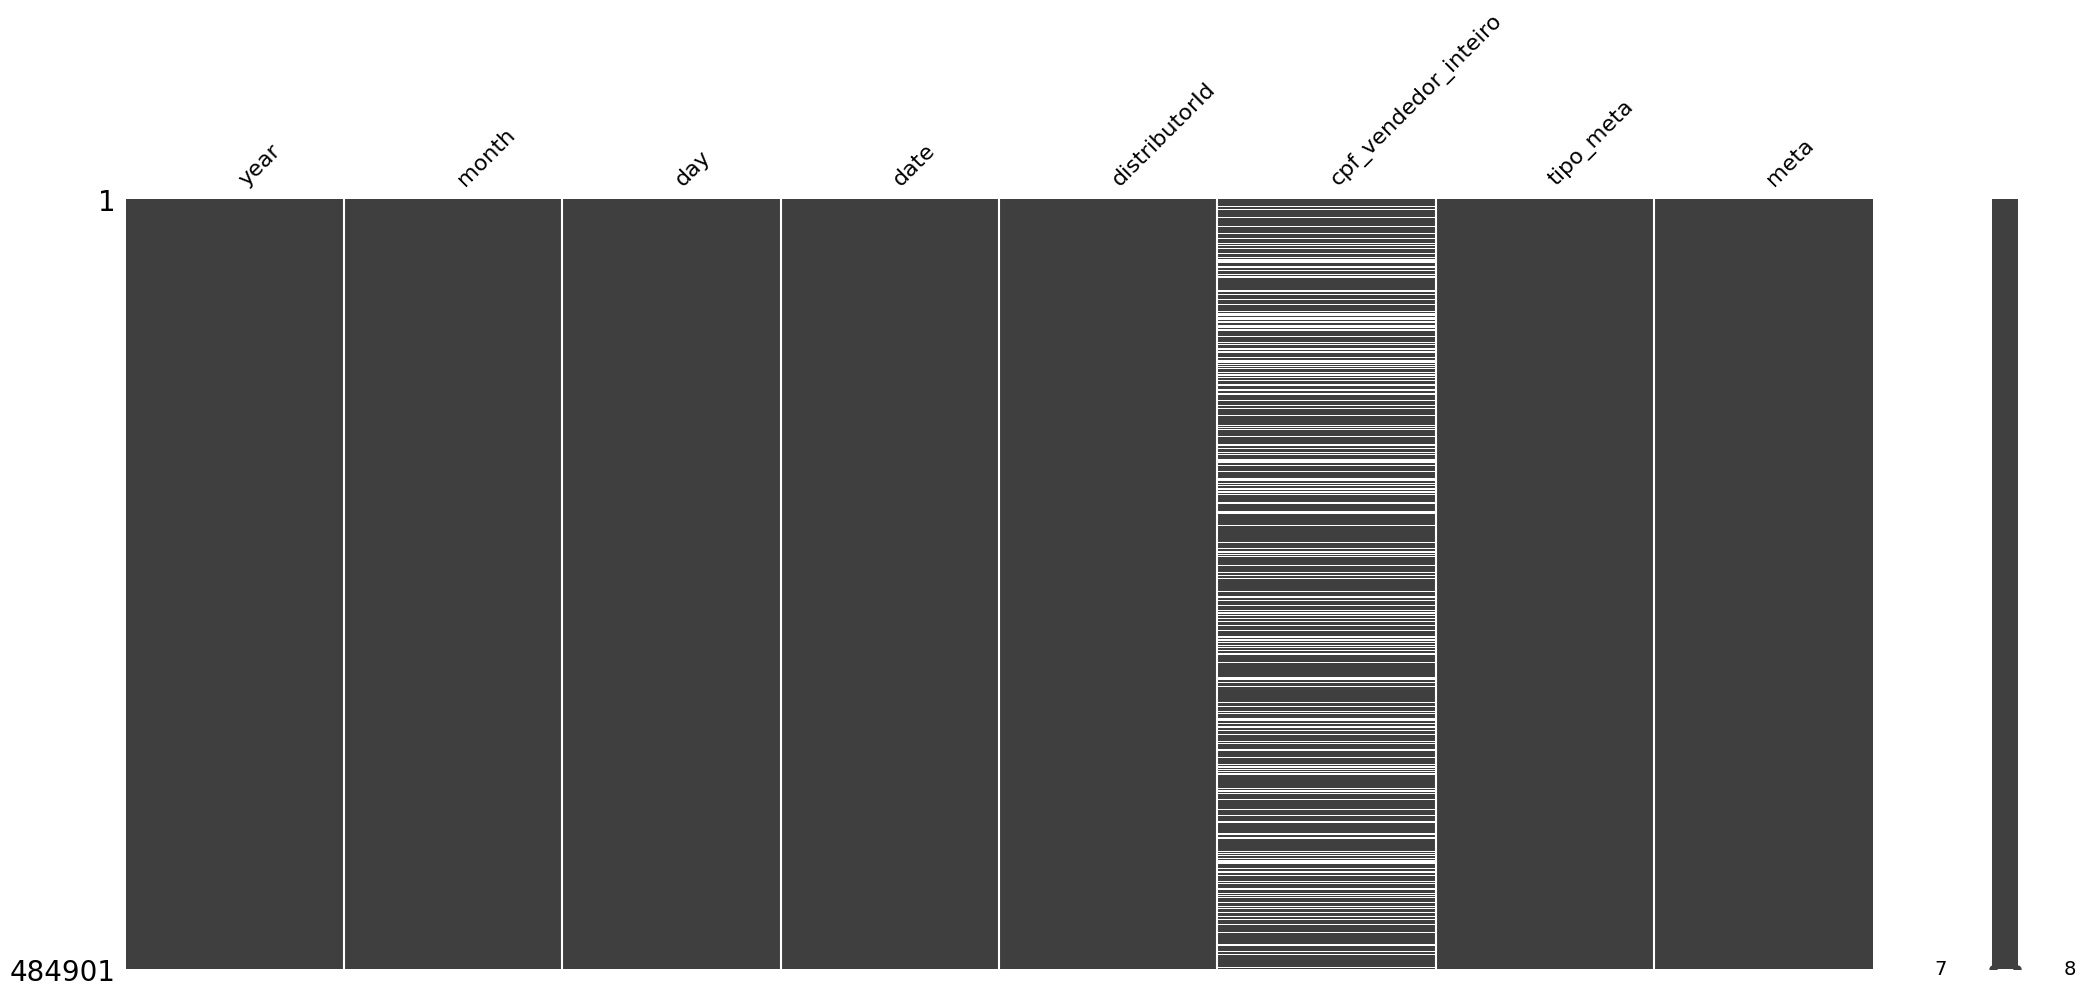

In [143]:
msno.matrix(df_metas)
df_metas['tipo_meta'].unique()

# Dúvidas

1: os valores de "gross_value", "full_value", "custo_cd", "store_cost" e "impostos_estimados" estão vindos zerados. A princípio eu estou ignorando esses valores, isso está correto?
- R: podemos ignorar esses campos

2: no campo "type" existem os valores de ['Outlet', 'CD', 'Franquia', 'Propria', 'CD-marketplace','Franquia - dropshipping']. Eu estou filtrando e calculando apenas os valores 'Propria' e ignorando os outros, está correto?
- R: filtrar apenas por propria está correto

3: no campo "esforco_data" existem vários valores vazios, então estou considerando o dia da venda por "createdAt". Está correto?

4: no campo "qry" podem vir os valores ['VENDA_LOJA', 'Q1', 'VENDA_CUPOM', 'FAT_CD'], é necessário realizar algum outro filtro para considerar apenas um desses valores?
- R: Pode ignorar o campo qry

5: no campo "cpf_cupom_vendedor" existem muitos valores vazios, essa coluna deve ser usada?
- R: ignorar valores vazios

6: no campo "cost" vários valores vem nulo. Como devemos tratar os valores vazios? Existe alguma maneira de preencher o custo ou podemos ignorar?
- R: ignorar campos vazios para o custo

7: no campo "vendedor_esforco" tem vários valores nulo. Como fazemos com os valores vazios?
- R: ignorar valores vazios para vendedor esforco. Considerar loja esforco no lugar de distributorId
